# Segmenting and Clustering Neighborhoods in New York City

## Introduction

In this project, I am extracting postal codes, Borough and Neighborhood of Canada using Web Scraping (Beautifulsoup) and then converting addresses into their equivalent latitude and longitude values. Also, I am using the Foursquare API to explore neighborhoods in Toronto City. I am using **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I am using the *k*-means clustering algorithm to complete this task. Finally, I am using the Folium library to visualize the neighborhoods in Toronto City and their emerging clusters.

# Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. Extracting Data from webpage to make Dataset

2. Explore Neighborhoods in Toronto City

3. Analyze Each Neighborhood

4. Cluster Neighborhoods

5. Examine Clusters  
</font>
</div>

### 1. Extracting Data from webpage to make Dataset

<div id='#item1'> As there is no Dataset of Canada directly availaible. So we are creating our own Dataset by Web Scraping data from the website <a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'>https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M</a> using Beautifulsoup package python </div>

#### Step 1 : Importing All Libraries

In [43]:
#Beautifulsoup library helps in web scraping data from webpage
from bs4 import BeautifulSoup
#lxml library is the parser used to parse the content from diffrent HTML Tags
import lxml
# Requests library helps in getting the content of the webpage
import requests as req
# library to handle data in a vectorized manner
import numpy as np
#library for Data Analysis
import pandas as pd
# library to handle JSON files
import json 
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
# library to handle requests
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# map rendering library
import folium 
print('Libraries imported.')

Libraries imported.


#### Step 2 : Web Scraping Data from the Webpage
We are extracting the data and writing the filtered data in the CSV file which is **demofile.csv**. After this step we are getting our raw dataset of Canada.

In [44]:
r = req.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(r.content,'lxml')
f = open("demofile.csv", "w")

hd=""
for header in soup.find_all('th'):
    hd=hd+','+header.text
hd=hd[1:31]

f.write(hd+'\n')
count=0
for record in soup.find_all('tr'):
    count+=1
    tdata=""
    for data in record.find_all('td'):
        tdata=tdata+','+data.text
    tdata=tdata[1:]
    if count==290:
        f.write(tdata)
        break
    f.write(tdata)
f.close()

#### Step 3: Reading the demofile.csv to dat dataframe. We can verify the content of dat dataframe using **dat.head()**.

In [45]:
dat=pd.read_csv('demofile.csv')
dat.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Step 4: Converting the 'Not Assigned' values to NaN in dat dataframe.

In [46]:
dat.replace('Not assigned',np.NaN,inplace=True)

#### Step 5: Droping the rows whose **Borough** is NaN.

In [47]:
dat.dropna(subset=['Borough'],inplace=True)

#### Step 6: If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [48]:
for index, row in dat.iterrows():
    if row['Neighbourhood']== 'NaN' or row['Neighbourhood']== '':
        row['Neighbourhood']=row['Borough']
    if row["Postcode"]=='M7A':
        row['Neighbourhood']=row['Borough']

#### Step 7: More than one neighborhood can exist in one postal code area. Those two rows will be combined into one row with the neighborhoods separated with a comma .

In [49]:
dat.Neighbourhood = dat.Neighbourhood.astype(str)
dat= dat.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
s=pd.Series(range(1,104)) 
dat.set_index(s,inplace=True)

### Step 8: Print the .shape method to print the number of rows of your dataframe.

In [50]:
dat.shape

(103, 3)

Now that I have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 
Using the Geocoder package or the csv file to create the following dataframe:



In [51]:
!wget -O Geospatial_Coordinates.csv https://cocl.us/Geospatial_data
geospat_data=pd.read_csv('Geospatial_Coordinates.csv')
count=0
dat_lat=[]
dat_lon=[]
for index1, row1 in dat.iterrows():
    for index2,row2 in geospat_data.iterrows():
        if str(row1["Postcode"])==str(row2["Postal Code"]):
            a=row2["Longitude"]
            b=row2["Latitude"]
            dat_lat.append(b)
            dat_lon.append(a)
dat['Longitude']=dat_lon
dat['Latitude']=dat_lat
dat.isnull().sum(axis=0)  
dat.to_csv('int_data.csv')
dat.head()

--2019-03-03 10:10:50--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.48.113.201
Connecting to cocl.us (cocl.us)|169.48.113.201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-03-03 10:10:53--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.24.197, 107.152.25.197
Connecting to ibm.box.com (ibm.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-03-03 10:10:54--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [followin

,Postcode,Borough,Neighbourhood,Longitude,Latitude
1,M1B,Scarborough,"Rouge, Malvern",-79.194353,43.806686
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",-79.160497,43.784535
3,M1E,Scarborough,"Guildwood, Morningside, West Hill",-79.188711,43.763573
4,M1G,Scarborough,Woburn,-79.216917,43.770992
5,M1H,Scarborough,Cedarbrae,-79.239476,43.773136


## 2. Explore the neighborhoods in Toronto City

In [52]:
P=[]
B=[]
N=[]
La=[]
Lo=[]
for index, row in dat.iterrows():
    if str(row['Borough']).find('Toronto')!=-1:
        P.append(row['Postcode'])
        B.append(row['Borough'])
        N.append(row['Neighbourhood'])
        La.append(row['Latitude'])
        Lo.append(row['Longitude'])
toronto_data=pd.DataFrame({'Postcode':P,'Borough':B,'Neighbourhood':N,'Longitude':Lo,'Latitude':La})
toronto_data.head()

,Postcode,Borough,Neighbourhood,Longitude,Latitude
0,M4E,East Toronto,The Beaches,-79.293031,43.676357
1,M4K,East Toronto,"The Danforth West, Riverdale",-79.352188,43.679557
2,M4L,East Toronto,"The Beaches West, India Bazaar",-79.315572,43.668999
3,M4M,East Toronto,Studio District,-79.340923,43.659526
4,M4N,Central Toronto,Lawrence Park,-79.388790,43.728020


In [53]:
#!conda install -c conda-forge geopy

Getting the Latitude of Toronto ,Ontario

In [54]:
from geopy.geocoders import Nominatim
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.653963, -79.387207.


### Marking the Neighborhoods of Toronto in the map using Folium 

In [55]:
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Assigning values to CLIENT_ID,CLIENT_SECRET ,VERSION,LIMIT for calling Foursquare API

In [56]:
CLIENT_ID = 'TZ2P2CCEDAWFAQXREEPK30XUHXJD20G4JMEKDH0PZ4KESADF' # your Foursquare ID
CLIENT_SECRET = '4FEVNVQT5FQ2XKR2X1YPSDM4NE3B4SC2BDDBSJB43VWDONCB' # your Foursquare Secret
VERSION = '20190226' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZ2P2CCEDAWFAQXREEPK30XUHXJD20G4JMEKDH0PZ4KESADF
CLIENT_SECRET:4FEVNVQT5FQ2XKR2X1YPSDM4NE3B4SC2BDDBSJB43VWDONCB


### Getting NearByVenues of each neighbourhood of the Borough Toronto

In [57]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [58]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
5,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
6,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
7,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
8,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
9,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677827,-79.350569,Greek Restaurant


In [59]:
#!conda install -c conda-forge geocoder

## 3. Analyse each Neighbourhood

In [60]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
2,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [61]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",19,19,19,19,19,19
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",48,48,48,48,48,48
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16


In [62]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 243 uniques categories.


In [63]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]



In [64]:
toronto_onehot.shape

(1708, 243)

In [65]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.01
1,Berczy Park,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.052632,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.0,0.0,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00


In [66]:
toronto_grouped.shape

(38, 243)

In [67]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2          Restaurant  0.05
3  Italian Restaurant  0.04
4                Café  0.04


----Brockton, Exhibition Place, Parkdale Village----
                   venue  freq
0         Breakfast Spot  0.11
1                   Café  0.11
2            Coffee Shop  0.11
3           Climbing Gym  0.05
4  Performing Arts Venue  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                venue  freq
0  Light Rail Station  0.11
1          Restaurant  0.05
2             Brewery  0.05
3          Smoke Shop  0.05
4       Burrito Place  0.05


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              ven

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Clothing Store,Bakery,Bar,Asian Restaurant,Hotel
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Farmers Market,Café,Pub,Cheese Shop,Seafood Restaurant,Italian Restaurant,Steakhouse
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Pet Store,Climbing Gym,Performing Arts Venue,Stadium,Burrito Place,Bar,Caribbean Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Pizza Place,Recording Studio,Moving Target,Restaurant,Butcher,Burrito Place,Brewery
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport


## 4. Clusters Neighborhoods

## Determining the Optimal K Value for KMeans algorithm

In [70]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for kclusters in K:
    kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

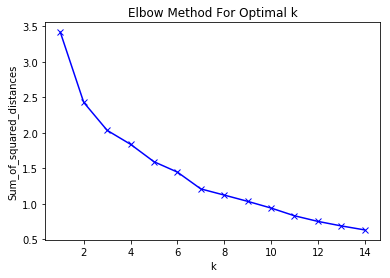

In [71]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above graph the Elbow point is in **k=7** which is the optimal value of K-Means clustering

In [72]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### Merging the two dataframe **toronto_data** and **neighborhoods_venues_sorted**

In [73]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Longitude,Latitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,-79.293031,43.676357,6,Coffee Shop,Health Food Store,Pub,Park,Falafel Restaurant,Farmers Market,Event Space,Fast Food Restaurant,Diner,Ethiopian Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",-79.352188,43.679557,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",-79.315572,43.668999,0,Pizza Place,Intersection,Pet Store,Gym,Pub,Movie Theater,Sandwich Place,Burrito Place,Burger Joint,Brewery
3,M4M,East Toronto,Studio District,-79.340923,43.659526,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
4,M4N,Central Toronto,Lawrence Park,-79.388790,43.728020,2,Bus Line,Park,Swim School,Dim Sum Restaurant,Women's Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [74]:
#neighborhoods_venues_sorted=neighborhoods_venues_sorted.drop('Cluster Label',1)
neighborhoods_venues_sorted.head()

,Cluster Label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Clothing Store,Bakery,Bar,Asian Restaurant,Hotel
1,0,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Farmers Market,Café,Pub,Cheese Shop,Seafood Restaurant,Italian Restaurant,Steakhouse
2,0,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Pet Store,Climbing Gym,Performing Arts Venue,Stadium,Burrito Place,Bar,Caribbean Restaurant
3,0,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Pizza Place,Recording Studio,Moving Target,Restaurant,Butcher,Burrito Place,Brewery
4,0,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Airport Service,Boutique,Sculpture Garden,Boat or Ferry,Plane,Airport Gate,Airport Food Court,Airport


In [75]:
#toronto_merged=toronto_merged.drop('Cluster Label',1)
#toronto_merged.head()

In [76]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

In [77]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,East Toronto,0,Pizza Place,Intersection,Pet Store,Gym,Pub,Movie Theater,Sandwich Place,Burrito Place,Burger Joint,Brewery
3,East Toronto,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Park,Brewery,Seafood Restaurant,Sandwich Place
5,Central Toronto,0,Gym,Burger Joint,Hotel,Park,Breakfast Spot,Sandwich Place,Clothing Store,Food & Drink Shop,Women's Store,Dumpling Restaurant
6,Central Toronto,0,Clothing Store,Sporting Goods Shop,Coffee Shop,Yoga Studio,Rental Car Location,Spa,Fast Food Restaurant,Mexican Restaurant,Diner,Sandwich Place
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Gym,Chinese Restaurant,Pharmacy
9,Central Toronto,0,Coffee Shop,Pub,American Restaurant,Convenience Store,Pizza Place,Vietnamese Restaurant,Fried Chicken Joint,Supermarket,Bagel Shop,Light Rail Station
11,Downtown Toronto,0,Coffee Shop,Restaurant,Café,Pizza Place,Italian Restaurant,Market,Pub,Bakery,Pharmacy,Park
12,Downtown Toronto,0,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Café,Fast Food Restaurant,Mediterranean Restaurant,Gastropub
13,Downtown Toronto,0,Coffee Shop,Park,Pub,Bakery,Café,Theater,Restaurant,Mexican Restaurant,Breakfast Spot,Electronics Store


In [78]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,1,Garden,Women's Store,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [79]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,2,Bus Line,Park,Swim School,Dim Sum Restaurant,Women's Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [80]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,3,Playground,Tennis Court,Gym,Restaurant,Dumpling Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant


In [81]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Downtown Toronto,4,Park,Playground,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [82]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,5,Bus Line,Trail,Sushi Restaurant,Jewelry Store,Women's Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


In [83]:
toronto_merged.loc[toronto_merged['Cluster Label'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,6,Coffee Shop,Health Food Store,Pub,Park,Falafel Restaurant,Farmers Market,Event Space,Fast Food Restaurant,Diner,Ethiopian Restaurant


# Conclusion

So from this above observations the common venue near the Neighborhoods of Toronto have been clustered into 7 Clusters .
And the same we can see in the world map.